In [1]:
!pip install opencv-python-headless



In [2]:
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
import pandas as pd
import json
from PIL import Image
import time
from google.colab.patches import cv2_imshow


In [3]:
# Load ResNet18
model = resnet18(pretrained=True)
model.eval()

# ImageNet normalization & resize
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get ImageNet labels
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
import urllib
labels = urllib.request.urlopen(LABELS_URL).read().decode().splitlines()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


In [4]:
# Load ResNet18
model = resnet18(pretrained=True)
model.eval()

# ImageNet normalization & resize
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get ImageNet labels
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
import urllib
labels = urllib.request.urlopen(LABELS_URL).read().decode().splitlines()


In [5]:
from google.colab import files
uploaded = files.upload() # User uploads image(s)

# Load uploaded image
img_path = list(uploaded.keys())[0]
frame = cv2.imread(img_path)
input_tensor = transform(frame).unsqueeze(0)


Saving download.jpg to download.jpg


In [6]:
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.nn.functional.softmax(output[0], dim=0).numpy()

top5_idx = np.argsort(probs)[-5:][::-1]
top_preds = [(labels[i], float(probs[i])) for i in top5_idx]

# Entropy estimation
entropy = -np.sum(probs * np.log(probs + 1e-12))
# Confidence gap analysis (diff between top two predictions)
conf_gap = float(probs[top5_idx[0]] - probs[top5_idx[1]])


In [7]:
gap_threshold = 0.2
entropy_threshold = 2.0
flagged = (conf_gap < gap_threshold) or (entropy > entropy_threshold)


In [9]:
import numpy as np

def convert_floats(obj):
    if isinstance(obj, dict):
        return {k: convert_floats(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_floats(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_floats(i) for i in obj)
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        return obj


In [10]:
json_safe_metadata = convert_floats(metadata)
with open(json_filename, "w") as f:
    json.dump(json_safe_metadata, f, indent=2)


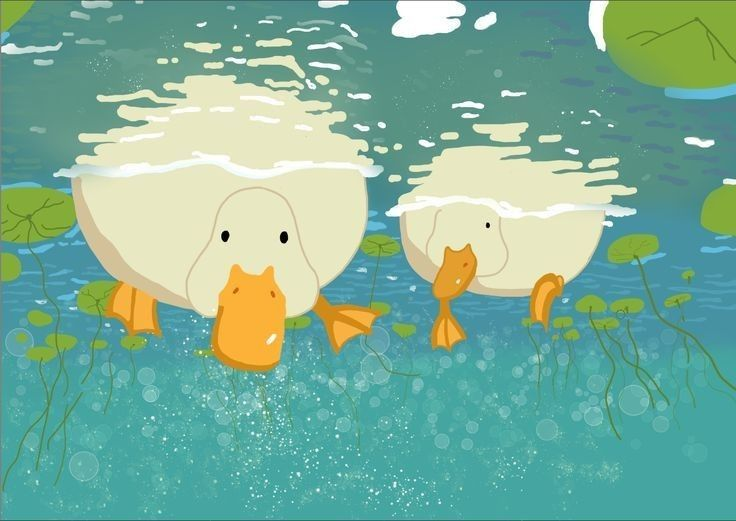

Top Predictions: [('bucket', 0.2483595758676529), ('pinwheel', 0.1075984314084053), ('stingray', 0.10277390480041504), ('jigsaw puzzle', 0.03191531077027321), ('black swan', 0.02757692150771618)]
Entropy: 3.7028666
Confidence Gap: 0.140761137008667
Flagged: True


In [11]:
cv2_imshow(frame)
print("Top Predictions:", top_preds)
print("Entropy:", entropy)
print("Confidence Gap:", conf_gap)
print("Flagged:", flagged)
